In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Global seed set to 0


In [2]:
results_folder = '/home/jupyter/CTCL/Visium/cell2loc_out'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [3]:
### object with raw counts
scRNA_path = '/home/jupyter/CTCL1-8_final_portal_rawcounts.h5ad'
adata_ref = sc.read(scRNA_path)

In [4]:
celltype_key = 'anno_final'
adata_ref.obs[celltype_key].value_counts()

tumourcell              42210
Th                      28289
Differentiated_KC       24020
CD8_cytox               20799
Treg                    17835
VE2                     12650
F2                      12458
CD8_RM                  10426
F3                       8899
CD4_CM-like              8164
Pericyte_1               7874
CD4_eff                  6701
Undifferentiated_KC      6701
B/plasma                 6073
Melanocyte               5751
Differentiated_KC*       5646
MoDC2                    3681
MoDC3                    3547
DC2                      3388
MonoMac                  3033
MoDC1                    3011
LC3                      2976
VE1                      2934
ILC1/3                   2588
CD8_CM-like              2332
LC4                      2247
DC1                      2217
ILC1/NK                  2168
Mac1                     2097
Mast                     2083
F1                       2080
Inf_Mac                  1421
LC2                      1398
Mac2      

In [5]:
adata_ref.var

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC233755.2,ENSG00000277856,Gene Expression
AC233755.1,ENSG00000275063,Gene Expression
AC240274.1,ENSG00000271254,Gene Expression
AC213203.1,ENSG00000277475,Gene Expression


In [6]:
# Use ENSEMBL as gene IDs to make sure IDs are unique and correctly matched
adata_ref.var['gene_names'] = adata_ref.var.index
adata_ref.var.index = adata_ref.var['gene_ids'].copy()
adata_ref.var_names = adata_ref.var['gene_ids'].copy()
adata_ref.var.index.name = None
adata_ref.var

,gene_ids,feature_types,gene_names
ENSG00000243485,ENSG00000243485,Gene Expression,MIR1302-2HG
ENSG00000237613,ENSG00000237613,Gene Expression,FAM138A
ENSG00000186092,ENSG00000186092,Gene Expression,OR4F5
ENSG00000238009,ENSG00000238009,Gene Expression,AL627309.1
ENSG00000239945,ENSG00000239945,Gene Expression,AL627309.3
...,...,...,...
ENSG00000277856,ENSG00000277856,Gene Expression,AC233755.2
ENSG00000275063,ENSG00000275063,Gene Expression,AC233755.1
ENSG00000271254,ENSG00000271254,Gene Expression,AC240274.1
ENSG00000277475,ENSG00000277475,Gene Expression,AC213203.1


## Estimation of reference cell type signatures (NB regression)

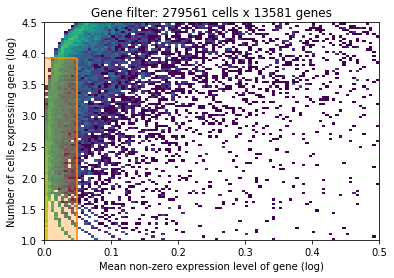

In [7]:
# before we estimate the reference cell type signature we recommend to perform very permissive genes selection
# in this 2D histogram orange rectangle lays over excluded genes.
# In this case, the downloaded dataset was already filtered using this method,
# hence no density under the orange rectangle

from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [9]:
# prepare anndata for the regression model
scvi.data.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='donor_id',
                        # cell type, covariate used for constructing signatures
                        labels_key=celltype_key
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        #categorical_covariate_keys=['patient']
                       )
scvi.data.view_anndata_setup(adata_ref)

INFO     Using batches from adata.obs["donor_id"]                                            
INFO     Using labels from adata.obs["anno_final"]                                           
INFO     Using data from adata.X                                                             


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 279561 cells, 13581 vars, 8       
         batches, 47 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.6.

              Data Summary               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃             Data             ┃ Count  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│            Cells             │ 279561 │
│             Vars             │ 13581  │
│            Labels            │   47   │
│           Batches            │   8    │
│           Proteins           │   0    │
│ Extra Categorical Covariates │   0    │
│ Extra Continuous Covariates  │   0    │
└──────────────────────────────┴────────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                            Label Categories                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃      Categories      ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['anno_final'] │       B/plasma       │          0          │
│                         │     CD4_CM-like      │          1          │
│                         │       CD4_eff        │          2          │
│                         │     CD8_CM-like      │          3          │
│                         │        CD8_RM        │          4          │
│                         │      CD8_cytox       │          5          │
│                         │         DC1          │          6          │
│                         │         DC2          │          7          │
│                         │  Differentiated_KC   │          8          │
│                         │  Differentiated_KC*  │          9          │
│                         │          F1          │         10          │
│                         │          F2          │         11          │
│                         │          F3          │         12          │
│                         │        ILC1/3        │         13          │
│                         │       ILC1/NK        │         14          │
│                         │       Inf_Mac        │         15          │
│                         │         LC1          │         16          │
│                         │         LC2          │         17          │
│                         │         LC3          │         18          │
│                         │         LC4          │         19          │
│                         │         LE1          │         20          │
│                         │         LE2          │         21          │
│                         │         Mac1         │         22          │
│                         │         Mac2         │         23          │
│                         │         Mast         │         24          │
│                         │      Melanocyte      │         25          │
│                         │       Mig_DC1        │         26          │
│                         │       Mig_DC2        │         27          │
│                         │        MoDC1         │         28          │
│                         │        MoDC2         │         29          │
│                         │        MoDC3         │         30          │
│                         │       MonoMac        │         31          │
│                         │        NK/CD8        │         32          │
│                         │      Pericyte_1      │         33          │
│                         │      Pericyte_2      │         34          │
│                         │  Proliferating_APC   │         35          │
│                         │ Proliferating_T-cell │         36          │
│                         │   Proliferating_KC   │         37          │
│                         │       Schwann        │         38          │
│                         │          Th          │         39          │
│                         │         Treg         │         40          │
│                         │ Undifferentiated_KC  │         41          │
│                         │         VE1          │         42          │
│                         │         VE2          │         43          │
│                         │         VE3          │         44          │
│                         │         pDC          │         45          │
│                         │      tumourcell      │         46          │
└─────────────────────────┴──────────────────────┴─────────────────────┘

                      Batch Categories                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor_id'] │   CTCL1    │          0          │
│                       │   CTCL2    │          1          │
│                       │   CTCL3    │          2          │
│                       │   CTCL4    │          3          │
│                       │   CTCL5    │          4          │
│                       │   CTCL6    │          5          │
│                       │   CTCL7    │          6          │
│                       │   CTCL8    │          7          │
└───────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [3:07:41<00:00, 22.52s/it, v_num=1, elbo_train=1.43e+9]  


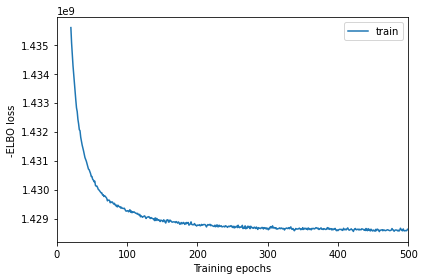

In [10]:
# create and train the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=500, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [11]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:17<00:00, 58.03it/s]


'/home/jupyter/CTCL/Visium/cell2loc_out/reference_signatures/sc.h5ad'

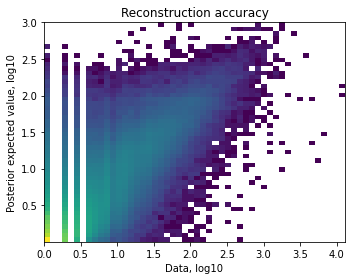

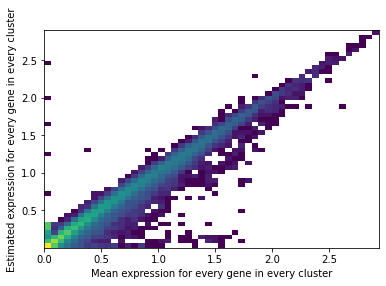

In [12]:
mod.plot_QC()

In [13]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

# save inf_aver
inf_aver.to_csv(f"{ref_run_name}/inf_aver.csv")